## Instalación de dependencias

In [2]:
# Install core libraries for text modeling and evaluation
%pip -q install -U datasets accelerate transformers peft trl bitsandbytes sentencepiece einops
%pip -q install -U matplotlib seaborn sentence_transformers

# helpers
%pip install wordcloud

# Install Accelerate for efficient training and device management
%pip install "accelerate>=0.26.0"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

# Use a single GPU to avoid DataParallel issues in notebooks.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Force Accelerate to disable mixed precision (stability fix for this environment).
os.environ["ACCELERATE_MIXED_PRECISION"] = "no"

## Importación de librerías

Esta sección carga todas las dependencias necesarias para el procesamiento de texto, entrenamiento del modelo y utilidades auxiliares.

In [4]:
# Core utilities
import re
import random
import math
import csv
import gc
from datetime import datetime, timedelta

# Data handling
import pandas as pd
from datasets import load_dataset, DatasetDict, Dataset

# Torch
import torch

# Transformers / QLoRA
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
)

# PEFT (LoRA)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    PeftModel,
)

# TRL (SFT for chat models)
from trl import SFTTrainer, SFTConfig

# Similarity models (opcional)
from sentence_transformers import SentenceTransformer, util

# Visualization (opcional)
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm import tqdm

sns.set(style="whitegrid")


## Configuración del dispositivo (CPU / GPU)

In [5]:
# Detect compute device (informativo)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo seleccionado: {device}")

if torch.cuda.is_available():
    print(f"GPUs disponibles: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        name = torch.cuda.get_device_name(i)
        cap = torch.cuda.get_device_capability(i)
        print(f"  GPU {i}: {name} — Compute Capability: {cap}")


Dispositivo seleccionado: cuda
GPUs disponibles: 1
  GPU 0: NVIDIA A30 — Compute Capability: (8, 0)


## Parámetros y filtros de datos irrelevantes

En esta sección se definen patrones típicos de WhatsApp que deben ser descartados durante la limpieza del dataset.

In [6]:
# Set of patterns considered irrelevant for training (WhatsApp system messages)
irrelevant_data = {
    # Spanish
    "eliminaste este mensaje",
    "se eliminó este mensaje",
    "<multimedia omitido>",
    "multimedia omitido",
    "los mensajes y las llamadas están cifrados de extremo a extremo",

    # English
    "you deleted this message",
    "this message was deleted",
    "<media omitted>",
    "media omitted",
    "messages and calls are end-to-end encrypted",
}

def contains_irrelevant_data(message: str) -> bool:
    """
    Returns True if the message contains any irrelevant WhatsApp system string.
    Assumes the input message has already been lowercased.
    """
    return any(pattern in message for pattern in irrelevant_data)


## Procesamiento del chat de WhatsApp

Esta celda contiene todas las funciones relacionadas con la limpieza, parseo y estructuración del chat de WhatsApp.
No realiza acciones por sí misma, solo define el procesamiento que luego será utilizado por la interfaz interactiva.
Contiene distintos separadores:

* Tags con los que el modelo fue entrenado: <|system|>, <|user|>, <|assistant|>, <|end|>
* Tags utilizados para los diferenciar interlocutores en los turnos [_Autor_], [OTRO]

In [7]:
MSG_SEP = "<|msg_sep|>"  # Separator used inside a single turn


def clean_text(text: str) -> str:
    """Light text normalization for WhatsApp messages."""
    text = text.lower().strip()
    text = re.sub(r"[^a-záéíóúñü0-9,.;:¡!¿?\s']", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def parse_datetime(line: str):
    """Parse WhatsApp timestamp from a message line, if present."""
    match = re.match(r"(\d+/\d+/\d+[, ]\s?\d+:\d+)\s-", line)
    if not match:
        return None

    raw = match.group(1).replace(",", "")
    for fmt in ("%d/%m/%y %H:%M", "%d/%m/%Y %H:%M"):
        try:
            return datetime.strptime(raw, fmt)
        except ValueError:
            continue
    return None


def group_consecutive_messages(messages):
    """Group consecutive messages from the same author when close in time."""
    grouped = []
    for author, msg, ts in messages:
        if (
            grouped
            and grouped[-1][0] == author
            and ts is not None
            and grouped[-1][2] is not None
            and (ts - grouped[-1][2]) < timedelta(hours=1)
        ):
            prev_author, prev_msg, prev_ts = grouped[-1]
            grouped[-1] = (author, f"{prev_msg} {MSG_SEP} {msg}", ts)
        else:
            grouped.append((author, msg, ts))
    return grouped


def process_whatsapp_chat_phi3(
    filepath: str,
    target_author: str,
    tokenizer,
    k_history: int = 4,
    time_gap: timedelta = timedelta(hours=3),
    system_prompt: str = "You are a helpful assistant.",
):
    """
    Returns a list of dicts with a single 'text' field formatted via Phi-3 chat template.
    Each example trains the assistant to respond as `target_author`.
    """
    print("Procesando chat (k-turns con roles) para Phi-3...")

    messages = []
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            ts = parse_datetime(line)
            match = re.match(r"\d+/\d+/\d+[, ]\s?\d+:\d+\s-\s([^:]+):\s(.+)", line)
            if not match:
                continue

            author = match.group(1).strip()
            raw_msg = match.group(2)
            msg = clean_text(raw_msg)

            if msg and not contains_irrelevant_data(msg):
                messages.append((author, msg, ts))

    if not messages:
        print("No se encontraron mensajes válidos.")
        return []

    messages = group_consecutive_messages(messages)
    print(f"Total de turnos agrupados: {len(messages)}")

    examples = []

    for i in range(1, len(messages)):
        author_i, msg_i, ts_i = messages[i]

        if author_i != target_author:
            continue

        context = []
        last_ts = ts_i

        for j in range(i - 1, -1, -1):
            a_j, m_j, ts_j = messages[j]

            if ts_j is not None and last_ts is not None and (last_ts - ts_j) > time_gap:
                break

            context.insert(0, (a_j, m_j))
            if ts_j is not None:
                last_ts = ts_j

            if len(context) >= k_history:
                break

        if not context:
            continue

        def fmt_turn(author: str, msg: str) -> str:
            speaker = f"[{target_author}]" if author == target_author else "[OTRO]"
            return f"{speaker} {msg}"

        context_str = " ".join(fmt_turn(a, m) for (a, m) in context)

        chat = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": context_str},
            {"role": "assistant", "content": msg_i},
        ]

        text = tokenizer.apply_chat_template(
            chat,
            tokenize=False,
            add_generation_prompt=False,
        )

        examples.append({"text": text})

    print(f"Total de ejemplos generados: {len(examples)}")
    return examples


## Carga del modelo base Phi-3 con QLoRA

Esta celda carga el modelo base Phi-3 Mini Instruct utilizando cuantización en 4 bits (QLoRA).
Se inicializa el tokenizer, se configura el padding y se prepara el modelo para fine-tuning eficiente mediante adapters LoRA.

In [8]:
MODEL_ID = "microsoft/Phi-3-mini-4k-instruct"

# QLoRA configuration (4-bit quantization)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    trust_remote_code=True,
    use_fast=True,
)

# Ensure a valid padding token is set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Base model loaded in 4-bit mode
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    use_cache=False,  # Disabled for training with gradient checkpointing
)

# Prepare model for k-bit (QLoRA) training
model = prepare_model_for_kbit_training(model)

print("✅ Tokenizer y modelo base cargados en 4-bit (listos para aplicar LoRA).")
print("pad_token:", tokenizer.pad_token, "| eos_token:", tokenizer.eos_token)


`torch_dtype` is deprecated! Use `dtype` instead!
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Tokenizer y modelo base cargados en 4-bit (listos para aplicar LoRA).
pad_token: <|endoftext|> | eos_token: <|endoftext|>


## Aplicación de adapters LoRA al modelo base

Esta celda configura y aplica LoRA (Low-Rank Adaptation) sobre el modelo base Phi-3 previamente cargado.
Se definen los hiperparámetros de LoRA y los módulos objetivo que serán ajustados durante el fine-tuning.

In [9]:
# LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        # Common projection layers used in transformer architectures
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
)

# Attach LoRA adapters to the base model
model = get_peft_model(model, lora_config)

# Display number of trainable vs frozen parameters
model.print_trainable_parameters()

print("✅ LoRA aplicado (modelo listo para SFTTrainer).")


trainable params: 8,912,896 || all params: 3,829,992,448 || trainable%: 0.2327
✅ LoRA aplicado (modelo listo para SFTTrainer).


## Procesamiento interactivo del chat

Esta celda ofrece una interfaz interactiva para cargar el archivo del chat, ingresar el nombre del autor y ajustar parámetros como el historial considerado y el tiempo máximo entre mensajes. Permite procesar el chat sin modificar código.

In [10]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# File upload widget for WhatsApp chat export (.txt)
chat_uploader = widgets.FileUpload(
    accept=".txt",
    multiple=False,
    description="Subir chat (.txt)"
)

# Text input for the target author (exactly as appears in the export)
author_input = widgets.Text(
    description="Autor:",
    placeholder="Nombre exactamente como figura en el chat",
    layout=widgets.Layout(width="60%")
)

# System prompt template (author name is injected at runtime)
SYSTEM_PROMPT_TEMPLATE = (
    "Sos un bot que responde mensajes de WhatsApp "
    "imitando el estilo conversacional de {author}"
)

# Slider for the number of history turns
k_history_slider = widgets.IntSlider(
    value=4,
    min=1,
    max=10,
    step=1,
    description="k_history:",
    continuous_update=False
)

# Slider for the time gap (in hours) to cut sessions
time_gap_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=24,
    step=1,
    description="time_gap (h):",
    continuous_update=False
)

# Button to trigger processing
process_button = widgets.Button(
    description="Procesar chat",
    button_style="primary"
)

output_proc = widgets.Output()


def on_process_clicked(_):
    with output_proc:
        clear_output()

        # Basic validation
        if len(chat_uploader.value) == 0:
            print("Por favor, sube un archivo de chat en formato .txt.")
            return

        target_author = author_input.value.strip()
        if not target_author:
            print("Por favor, ingresa el nombre del autor exactamente como aparece en el chat.")
            return

        system_prompt = SYSTEM_PROMPT_TEMPLATE.format(author=target_author)

        # Extract uploaded file content
        upload_info = chat_uploader.value[0]
        content = bytes(upload_info["content"]).decode("utf-8-sig", errors="replace")

        # Save to a temporary file for reuse
        tmp_path = "uploaded_chat.txt"
        with open(tmp_path, "w", encoding="utf-8") as f:
            f.write(content)

        # Process chat and expose results as a global variable
        global train_examples
        train_examples = process_whatsapp_chat_phi3(
            filepath=tmp_path,
            target_author=target_author,
            tokenizer=tokenizer,
            k_history=k_history_slider.value,
            time_gap=timedelta(hours=time_gap_slider.value),
            system_prompt=system_prompt,
        )

        print(f"Ejemplos generados: {len(train_examples)}")
        if train_examples:
            print("\nEjemplo de TEXT (Phi-3 chat template):")
            ex = train_examples[0]["text"]
            print(ex[:800] + ("..." if len(ex) > 800 else ""))

        print("\nVariable disponible para las siguientes celdas: 'train_examples'.")


process_button.on_click(on_process_clicked)

display(
    widgets.VBox([
        widgets.HTML("<b>Procesamiento interactivo del chat de WhatsApp</b>"),
        chat_uploader,
        author_input,
        k_history_slider,
        time_gap_slider,
        process_button,
        output_proc,
    ])
)


## Creación del dataset, limpieza y guardado

Esta celda toma los ejemplos generados previamente, construye un DataFrame, aplica una limpieza básica (elimina ejemplos triviales y enlaces) y guarda un archivo CSV con el dataset inicial. Además, muestra algunos ejemplos aleatorios para inspeccionar el resultado.

In [11]:
# Safety check: train_examples must exist
if "train_examples" not in globals():
    raise RuntimeError(
        "La variable 'train_examples' no existe. "
        "Ejecuta primero el procesamiento interactivo del chat (Phi-3) para generar 'train_examples'."
    )


def build_dataset_from_text(
    examples,
    min_words: int = 12,
    filter_links: bool = True,
):
    """
    Build a DataFrame from Phi-3 formatted samples (each sample is {"text": ...}).
    The function drops invalid rows, filters very short samples, and optionally removes URLs.
    """
    df = pd.DataFrame(examples)
    if "text" not in df.columns:
        raise ValueError("Cada ejemplo debe tener la clave 'text'.")

    df = df.dropna(subset=["text"]).reset_index(drop=True)
    df = df[df["text"].str.split().str.len() >= min_words].reset_index(drop=True)

    if filter_links:
        df = df[~df["text"].str.contains(r"http|www|\.com", regex=True)].reset_index(drop=True)

    return df


# Default configuration
min_words_default = 12
filter_links_default = True
output_path_default = "train_data_phi3_text.csv"

data = build_dataset_from_text(
    train_examples,
    min_words=min_words_default,
    filter_links=filter_links_default,
)

data.to_csv(output_path_default, index=False, quoting=csv.QUOTE_ALL)

print(f"Dataset inicial guardado → {len(data)} ejemplos.")
print("\nVista aleatoria de algunos ejemplos:\n")

for _ in range(min(5, len(data))):
    s = data.sample(1).iloc[0]
    text = s["text"]
    print(f"TEXT (Phi-3):\n{text[:900]}{'...' if len(text) > 900 else ''}\n{'-'*70}")


Dataset inicial guardado → 22185 ejemplos.

Vista aleatoria de algunos ejemplos:

TEXT (Phi-3):
<|system|>
Sos un bot que responde mensajes de WhatsApp imitando el estilo conversacional de Nico Bazan<|end|>
<|user|>
[OTRO] bazi vos ponés los for adentro de un always?<|end|>
<|assistant|>
eeh no me acuerdo ya me fijo <|msg_sep|> para los tests imagino q decis <|msg_sep|> en un initial lo pongo<|end|>
<|endoftext|>
----------------------------------------------------------------------
TEXT (Phi-3):
<|system|>
Sos un bot que responde mensajes de WhatsApp imitando el estilo conversacional de Nico Bazan<|end|>
<|user|>
[Nico Bazan] y que vas a rendir? [OTRO] nada [Nico Bazan] a pye no llegas? [OTRO] no ya no<|end|>
<|assistant|>
hmm : <|msg_sep|> bueno entonces disfruta estos días! <|msg_sep|> vacaciones ?<|end|>
<|endoftext|>
----------------------------------------------------------------------
TEXT (Phi-3):
<|system|>
Sos un bot que responde mensajes de WhatsApp imitando el estilo conver

## Filtrado semántico global

Esta celda aplica un filtrado semántico basado en embeddings para conservar únicamente ejemplos con alta coherencia semántica entre el mensaje del usuario y la respuesta del asistente.
Se calcula la similitud coseno, se filtran ejemplos ruidosos y se guarda el dataset final.

In [12]:
import re

# Load the sentence transformer model once
if "model_emb" not in globals():
    model_emb = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")


def extract_user_and_assistant(phi3_text: str):
    """
    Extracts the first <|user|> ... <|end|> and <|assistant|> ... <|end|> blocks
    from a Phi-3 formatted text.
    Returns (user_text, assistant_text) or (None, None) if parsing fails.
    """
    if not isinstance(phi3_text, str):
        return None, None

    user_match = re.search(r"<\|user\|>\s*(.*?)\s*<\|end\|>", phi3_text, flags=re.DOTALL)
    asst_match = re.search(r"<\|assistant\|>\s*(.*?)\s*<\|end\|>", phi3_text, flags=re.DOTALL)

    user_text = user_match.group(1).strip() if user_match else None
    assistant_text = asst_match.group(1).strip() if asst_match else None
    return user_text, assistant_text


# Build user / assistant columns from Phi-3 text
ua = data["text"].apply(extract_user_and_assistant)
data["user_text"] = ua.apply(lambda x: x[0])
data["assistant_text"] = ua.apply(lambda x: x[1])

# Drop rows that could not be parsed correctly
data = data.dropna(subset=["user_text", "assistant_text"]).reset_index(drop=True)

# Encode user and assistant messages
emb_users = model_emb.encode(
    data["user_text"].tolist(),
    convert_to_tensor=True,
    show_progress_bar=True,
)
emb_assts = model_emb.encode(
    data["assistant_text"].tolist(),
    convert_to_tensor=True,
    show_progress_bar=True,
)

# Compute cosine similarity for each pair
similarities = util.cos_sim(emb_users, emb_assts).diagonal().cpu().numpy()
data["similarity"] = similarities

print(f"Media de similitud: {data['similarity'].mean():.3f}")

# Filtering configuration
SIM_THRESHOLD = 0.30
MAX_USER_LEN = 1200
MAX_ASSISTANT_LEN = 800

filtered = data[
    (data["similarity"] > SIM_THRESHOLD)
    & (data["user_text"].str.len() < MAX_USER_LEN)
    & (data["assistant_text"].str.len() < MAX_ASSISTANT_LEN)
].reset_index(drop=True)

# Save final training dataset (Phi-3 text only)
output_filtered_path = "filtered_train_phi3_text.csv"
filtered[["text"]].to_csv(output_filtered_path, index=False, quoting=csv.QUOTE_ALL)

# Optional debug dataset for inspection
output_debug_path = "filtered_train_phi3_debug.csv"
filtered[["user_text", "assistant_text", "similarity"]].to_csv(
    output_debug_path, index=False, quoting=csv.QUOTE_ALL
)

print(f"Dataset final (solo text) guardado en '{output_filtered_path}'.")
print(f"Dataset debug guardado en '{output_debug_path}'.")
print(f"Total de ejemplos útiles: {len(filtered)} (de {len(data)}).")

print("\nVista rápida de algunos ejemplos filtrados:\n")
for _ in range(min(3, len(filtered))):
    s = filtered.sample(1).iloc[0]
    print(
        f"USER:\n{s['user_text']}\n"
        f"→ ASSISTANT:\n{s['assistant_text']}\n"
        f"Similarity: {s['similarity']:.3f}\n"
        + "-" * 70
    )

Batches:   0%|          | 0/694 [00:00<?, ?it/s]

Batches:   0%|          | 0/694 [00:00<?, ?it/s]

Media de similitud: 0.450
Dataset final (solo text) guardado en 'filtered_train_phi3_text.csv'.
Dataset debug guardado en 'filtered_train_phi3_debug.csv'.
Total de ejemplos útiles: 18695 (de 22185).

Vista rápida de algunos ejemplos filtrados:

USER:
[Nico Bazan] ahora los veo jaja <|msg_sep|> supongo que ayudaran <|msg_sep|> ademas <|msg_sep|> si le pido ayuda va a decir <|msg_sep|> che vieron los videos? [OTRO] claro por eso principalmente jaja [Nico Bazan] vos los viste? <|msg_sep|> estaba comiendo [OTRO] todavia no
→ ASSISTANT:
de una <|msg_sep|> que comiste?
Similarity: 0.467
----------------------------------------------------------------------
USER:
[Nico Bazan] seguís mejor q yo jajaj <|msg_sep|> creo que si [OTRO] xd [Nico Bazan] no me acompañas al final? jajaja [OTRO] espero que no disculpa bazi xdd <|msg_sep|> pero por ahí si c: <|msg_sep|> eso no lo sé
→ ASSISTANT:
jajaja si espero que yo tampoco pero no va bien
Similarity: 0.560
--------------------------------------------

## Preparación del dataset para entrenamiento

Esta celda carga el dataset filtrado en formato Phi-3 (text), realiza una limpieza mínima, lo convierte a datasets.Dataset y lo divide en entrenamiento y validación.

In [13]:
# Load and minimally clean the dataset (Phi-3 format: 'text' column)
data = pd.read_csv("filtered_train_phi3_text.csv")
data = data.dropna(subset=["text"])
data = data[data["text"].str.strip() != ""].reset_index(drop=True)
data.to_csv("filtered_train_phi3_text.csv", index=False, quoting=csv.QUOTE_ALL)

# Load into HuggingFace datasets
dataset = load_dataset("csv", data_files="filtered_train_phi3_text.csv")

# Train/validation split
train_test = dataset["train"].train_test_split(test_size=0.2, seed=42)
datasets = DatasetDict(
    {"train": train_test["train"], "validation": train_test["test"]}
)

print(datasets)
print("Ejemplo:")
print(datasets["train"][0]["text"][:400])


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 14956
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3739
    })
})
Ejemplo:
<|system|>
Sos un bot que responde mensajes de WhatsApp imitando el estilo conversacional de Nico Bazan<|end|>
<|user|>
[Nico Bazan] de una <|msg_sep|> que cenaste? [OTRO] sopa [Nico Bazan] que rico [OTRO] sipp<|end|>
<|assistant|>
estás a full con la sopa últimamente<|end|>
<|endoftext|>


### Análisis estadístico y calidad del dataset por etapas

Este bloque analiza el dataset conversacional a lo largo de todas las etapas de preprocesamiento disponibles (por ejemplo: pares raw generados → dataset inicial con filtros básicos → dataset final con filtros adicionales).
El objetivo es entender cómo cambia el conjunto de datos con cada filtrado, evaluar su calidad y verificar que el dataset final sea adecuado para el entrenamiento supervisado del modelo.

En particular, se reportan las siguientes métricas:

* Stage: indica a qué etapa del pipeline corresponde cada fila (raw / inicial / final).

* Samples: cantidad total de ejemplos (pares prompt–response) disponibles en esa etapa.

* Exact duplicates: número de ejemplos idénticos detectados. Un valor bajo sugiere que no hay sobre-representación artificial de pares repetidos.

* Chars avg: longitud promedio del texto por ejemplo medida en caracteres. Da una noción general del tamaño del contenido sin depender del tokenizer.

* Words avg: cantidad promedio de palabras por ejemplo (estimación lingüística), útil como medida intuitiva de longitud.

* Words p95: percentil 95 de la longitud en palabras. Indica que el 95% de los ejemplos tiene una longitud menor o igual a este valor y permite identificar ejemplos largos.

* Unique words: número total de palabras distintas presentes (tamaño del vocabulario).

* Vocab richness (%): proporción entre palabras únicas y el total de palabras. Valores relativamente bajos son esperables en chats personales y reflejan consistencia de estilo y repetición de expresiones.

* Tokens avg: cantidad promedio de tokens por ejemplo según el tokenizer del modelo, que representa lo que realmente procesa el modelo.

* Tokens p95: percentil 95 de la longitud en tokens. Es una métrica clave para estimar el uso de contexto y evitar truncamiento durante el entrenamiento.

* Además, se incluye un ranking de las palabras más frecuentes por etapa, útil para:

* Detectar muletillas o expresiones dominantes

* Identificar ruido residual (tokens del template, separadores, etc.)

* Caracterizar el estilo conversacional que el modelo aprenderá


📊 Resumen de estadísticas por etapa


,stage,samples,exact_duplicates,chars_avg,words_avg,words_p95,unique_words,vocab_richness_pct,tokens_avg,tokens_p95
0,Raw (train_examples),22672,5,547.634439,48.754984,108.0,23416,2.118380,186.784095,338.0
1,Inicial (data),18695,5,550.602514,48.934260,107.0,22131,2.419149,188.310190,339.0
2,Final (filtered),18695,5,550.602514,48.934260,107.0,22131,2.419149,188.310190,339.0
3,HF Train (datasets['train']),14956,4,550.089596,48.865539,107.0,21268,2.910104,188.098556,338.0
4,HF Val (datasets['validation']),3739,0,552.654186,49.209147,109.0,12561,6.826890,189.156726,347.0



🔝 Top 20 palabras por etapa
Se muestran dos vistas: frecuencia cruda e informativa (sin stopwords).

Etapa: Raw (train_examples)


Con muletillas              Sin muletillas           
          palabra frecuencia          palabra frecuencia
0              no      43202               xd      16553
1             que      31706              eso       7787
2              de      28298            bueno       7623
3              si      25019             como       6702
4              me      24511              vos       6574
5              el      19429             creo       5774
6              la      19333            ahora       4923
7            pero      18848            hacer       4840
8              xd      16553              voy       4546
9              lo      14497            estoy       4427
10             es      14153             nada       4390
11             se      13701             algo       4387
12             en      13566               al       4301
13             te      10723            tengo       4295
14             yo       9391              mal       4211
15             un       9210              hay       4210
16            una       8396            igual       4127
17            con       8125             esta       3754
18             ya       7962             todo       3741
19           bien       7834              mas       3727


Etapa: Inicial (data)


Con muletillas              Sin muletillas           
          palabra frecuencia          palabra frecuencia
0              no      35980               xd      13731
1             que      26531              eso       6361
2              de      23152            bueno       6360
3              me      20729              vos       5750
4              si      20526             como       5603
5              la      15890             creo       4798
6              el      15816            ahora       4270
7            pero      15616            hacer       4068
8              xd      13731              voy       3908
9              lo      11871            estoy       3743
10             se      11500             nada       3700
11             es      11477             algo       3633
12             en      11118               al       3542
13             te       9016            tengo       3537
14             yo       7896              mal       3530
15             un       7622              hay       3489
16            una       6932            igual       3457
17             ya       6794              mas       3166
18           bien       6771             esta       3133
19            con       6764             todo       3124


Etapa: Final (filtered)


Con muletillas              Sin muletillas           
          palabra frecuencia          palabra frecuencia
0              no      35980               xd      13731
1             que      26531              eso       6361
2              de      23152            bueno       6360
3              me      20729              vos       5750
4              si      20526             como       5603
5              la      15890             creo       4798
6              el      15816            ahora       4270
7            pero      15616            hacer       4068
8              xd      13731              voy       3908
9              lo      11871            estoy       3743
10             se      11500             nada       3700
11             es      11477             algo       3633
12             en      11118               al       3542
13             te       9016            tengo       3537
14             yo       7896              mal       3530
15             un       7622              hay       3489
16            una       6932            igual       3457
17             ya       6794              mas       3166
18           bien       6771             esta       3133
19            con       6764             todo       3124


Etapa: HF Train (datasets['train'])


Con muletillas              Sin muletillas           
          palabra frecuencia          palabra frecuencia
0              no      28795               xd      10953
1             que      21241            bueno       5095
2              de      18410              eso       5055
3              me      16478              vos       4566
4              si      16435             como       4509
5              el      12674             creo       3837
6              la      12595            ahora       3420
7            pero      12465            hacer       3238
8              xd      10953              voy       3061
9              lo       9536             nada       2943
10             se       9236            estoy       2939
11             es       9102             algo       2920
12             en       8973               al       2867
13             te       7213              mal       2864
14             yo       6240            tengo       2850
15             un       5995              hay       2783
16            una       5481            igual       2764
17           bien       5442             esta       2521
18            con       5436              mas       2516
19             ya       5409             todo       2495


Etapa: HF Val (datasets['validation'])


Con muletillas              Sin muletillas           
          palabra frecuencia          palabra frecuencia
0              no       7185               xd       2778
1             que       5290              eso       1306
2              de       4742            bueno       1265
3              me       4251              vos       1184
4              si       4091             como       1094
5              la       3295             creo        961
6            pero       3151            ahora        850
7              el       3142              voy        847
8              xd       2778            hacer        830
9              es       2375            estoy        804
10             lo       2335             nada        757
11             se       2264             algo        713
12             en       2145              hay        706
13             te       1803            igual        693
14             yo       1656            tengo        687
15             un       1627               al        675
16            una       1451              mal        666
17             ya       1385              mas        650
18           bien       1329             todo        629
19            con       1328             esta        612


🖼️ Nube de palabras (stage elegido)
Etapa usada: Final (filtered)


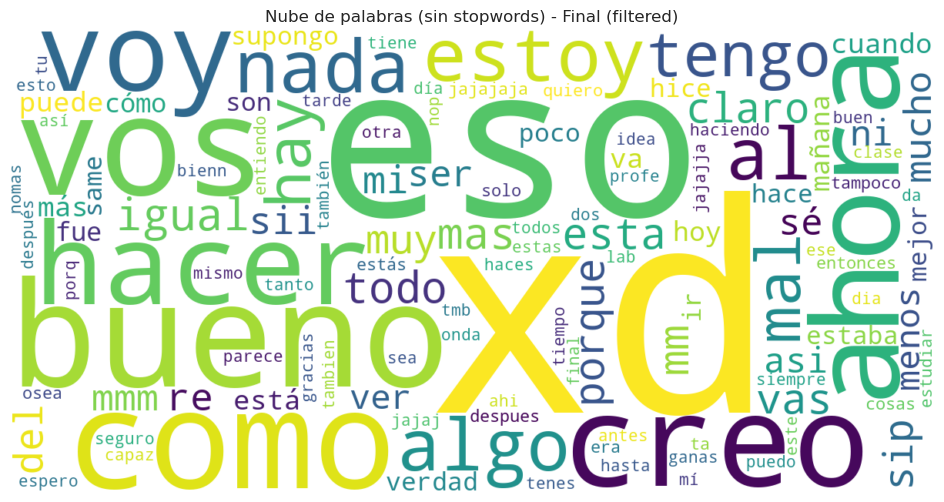

• Modelo objetivo: Phi-3 Instruct (dataset en formato chat-template con columna 'text')
• Nota: el bloque <|system|>...<|end|> se elimina SOLO para estadísticas (para no sesgar por el system prompt).
• Tags comunes en Phi-3: <|system|>, <|user|>, <|assistant|>, <|end|>
• Etapas analizadas: Raw (train_examples), Inicial (data), Final (filtered), HF Train (datasets['train']), HF Val (datasets['validation'])
• Tamaño inicial: 22672 ejemplos
• Tamaño final: 3739 ejemplos
• Reducción total: 83.51%


In [16]:
import re
from collections import Counter
import pandas as pd

# Optional: word cloud visualization (if available)
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except Exception:
    WORDCLOUD_AVAILABLE = False

import matplotlib.pyplot as plt

# -----------------------------
# Helpers for word stats
# -----------------------------
WORD_RE = re.compile(r"[a-záéíóúñü0-9']+")

# Phi-3 template tags / leftovers (for stats only)
TAG_RE_GENERIC = re.compile(r"<\|.*?\|>")

# Remove the WHOLE system block for Phi-3: <|system|> ... <|end|>
SYSTEM_BLOCK_PHI3_RE = re.compile(r"<\|system\|>\s*.*?\s*<\|end\|>", re.DOTALL)

# --- Dynamically exclude target author name from stats (if available)
AUTHOR_STOP_WORDS = set()
if "author_input" in globals() and author_input.value.strip():
    AUTHOR_STOP_WORDS = {
        w for w in re.findall(r"[a-záéíóúñü]+", author_input.value.strip().lower())
        if len(w) >= 2
    }

# Template leftovers / role tokens that should never count as "words"
STOP_WORDS_EXTRA = {
    "user", "assistant", "system",
    "metadata", "knowledge", "cutoff", "date", "today",
    "reasoning", "mode", "custom", "instructions",
    "msg_sep", "otro",
    # Phi-3 specific leftovers that may remain after stripping <|...|>
    "im_start", "im_end", "end"
}.union(AUTHOR_STOP_WORDS)

# --- Spanish stopwords for "informative words" view (simple + controllable)
SPANISH_STOPWORDS = {
    "el","la","los","las","un","una","unos","unas",
    "yo","me","te","se","lo","le","nos","les",
    "de","que","y","o","pero","si","no","es","en","con","por","para",
    "ya","bien","eh","ah","oh","jaja","jajaja"
}

def normalize_for_stats(text: str) -> str:
    """
    Normalization used ONLY for statistics (not training).
    - Removes the whole Phi-3 system block (<|system|>...<|end|>) to avoid bias from SYSTEM_PROMPT_TEMPLATE.
    - Removes remaining <|...|> tags.
    - Normalizes case/whitespace and removes raw numbers.
    """
    if not isinstance(text, str):
        return ""

    # 1) Remove full system prompt block (Phi-3)
    text = SYSTEM_BLOCK_PHI3_RE.sub(" ", text)

    # 2) Remove any remaining template tags
    text = TAG_RE_GENERIC.sub(" ", text)

    # 3) Normalize
    text = text.replace("\n", " ").lower()
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def extract_words(text: str):
    """
    Raw frequency words (keeps muletillas, removes template leftovers).
    """
    words = WORD_RE.findall(normalize_for_stats(text))
    words = [w for w in words if w not in STOP_WORDS_EXTRA and len(w) >= 2]
    return words

def extract_informative_words(text: str):
    """
    Informative frequency words (stopwords removed).
    """
    words = extract_words(text)
    return [w for w in words if w not in SPANISH_STOPWORDS]

def compute_text_stats(texts, stage_name: str):
    """
    Compute dataset-level stats from a list of texts.
    """
    texts = [t for t in texts if isinstance(t, str) and t.strip()]
    n = len(texts)

    char_lengths = [len(t) for t in texts]
    word_lengths = [len(extract_words(t)) for t in texts]

    vocab = Counter()
    for t in texts:
        vocab.update(extract_words(t))

    stats = {
        "stage": stage_name,
        "samples": n,
        "exact_duplicates": int(pd.Series(texts).duplicated().sum()),
        "chars_avg": float(sum(char_lengths) / max(1, n)),
        "words_avg": float(sum(word_lengths) / max(1, n)),
        "words_p95": float(pd.Series(word_lengths).quantile(0.95)) if n else 0.0,
        "unique_words": int(len(vocab)),
        "vocab_richness_pct": 100.0 * len(vocab) / max(1, sum(vocab.values())),
    }

    # Token stats only if tokenizer exists
    if "tokenizer" in globals() and tokenizer is not None:
        try:
            token_lengths = [len(tokenizer(t, add_special_tokens=False).input_ids) for t in texts]
            stats.update({
                "tokens_avg": float(sum(token_lengths) / max(1, n)),
                "tokens_p95": float(pd.Series(token_lengths).quantile(0.95)) if n else 0.0,
            })
        except Exception:
            pass

    return stats, vocab

def maybe_show_wordcloud(vocab: Counter, title: str, max_words: int = 120):
    """
    Show a word cloud (palabras más usadas más grandes).
    Requires 'wordcloud'. If unavailable, it will skip gracefully.
    """
    if not WORDCLOUD_AVAILABLE:
        print("ℹ️ WordCloud no está disponible (instalá: pip install wordcloud) para ver la nube de palabras.")
        return

    if not vocab:
        print("ℹ️ No hay vocabulario suficiente para generar la nube de palabras.")
        return

    wc = WordCloud(
        width=1200,
        height=600,
        background_color="white",
        max_words=max_words,
        collocations=False
    ).generate_from_frequencies(dict(vocab))

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# -----------------------------
# Collect stages dynamically (Phi-3 pipeline)
# -----------------------------
stages = []
vocabs_raw = {}

# Stage A: Raw processed examples -> train_examples (list of {"text": ...})
if "train_examples" in globals() and isinstance(train_examples, list) and len(train_examples) > 0:
    raw_texts = [ex.get("text", "") for ex in train_examples if isinstance(ex, dict)]
    raw_texts = [t for t in raw_texts if isinstance(t, str) and t.strip()]
    if raw_texts:
        stages.append(("Raw (train_examples)", raw_texts))

# Stage B: Initial dataset -> data (DataFrame with 'text' column)
if "data" in globals() and isinstance(data, pd.DataFrame) and "text" in data.columns:
    data_texts = data["text"].astype(str).tolist()
    data_texts = [t for t in data_texts if t.strip()]
    stages.append(("Inicial (data)", data_texts))

# Stage C: Final filtered dataset -> filtered (DataFrame with 'text' column)
if "filtered" in globals() and isinstance(filtered, pd.DataFrame) and "text" in filtered.columns:
    filtered_texts = filtered["text"].astype(str).tolist()
    filtered_texts = [t for t in filtered_texts if t.strip()]
    stages.append(("Final (filtered)", filtered_texts))

# Stage D: HuggingFace split (optional) -> datasets["train"], datasets["validation"]
if "datasets" in globals():
    try:
        if "train" in datasets and "text" in datasets["train"].column_names:
            stages.append(("HF Train (datasets['train'])", [x["text"] for x in datasets["train"]]))
        if "validation" in datasets and "text" in datasets["validation"].column_names:
            stages.append(("HF Val (datasets['validation'])", [x["text"] for x in datasets["validation"]]))
    except Exception:
        pass

if not stages:
    raise RuntimeError(
        "No se detectaron etapas para analizar. "
        "Necesito al menos una de estas variables: train_examples, data, filtered, datasets."
    )

# -----------------------------
# Compute and display summary
# -----------------------------
rows = []
for stage_name, texts in stages:
    stats, vocab = compute_text_stats(texts, stage_name)
    rows.append(stats)
    vocabs_raw[stage_name] = vocab

summary_df = pd.DataFrame(rows)

base_cols = [
    "stage", "samples", "exact_duplicates",
    "chars_avg", "words_avg", "words_p95",
    "unique_words", "vocab_richness_pct"
]
token_cols = [c for c in ["tokens_avg", "tokens_p95"] if c in summary_df.columns]

print("\n📊 Resumen de estadísticas por etapa")
display(summary_df[base_cols + token_cols])

# -----------------------------
# Top words per stage: raw + informative (side-by-side + spacing + grouped header)
# -----------------------------
TOP_K = 20
print(f"\n🔝 Top {TOP_K} palabras por etapa")
print("Se muestran dos vistas: frecuencia cruda e informativa (sin stopwords).")

for stage_name, texts in stages:
    print("\n" + "=" * 80)
    print(f"Etapa: {stage_name}")

    # Raw frequency (includes muletillas)
    top_raw = pd.DataFrame(
        vocabs_raw[stage_name].most_common(TOP_K),
        columns=["palabra", "frecuencia"]
    )

    # Informative frequency (stopwords removed)
    vocab_info = Counter()
    for t in texts:
        vocab_info.update(extract_informative_words(t))

    top_info = pd.DataFrame(
        vocab_info.most_common(TOP_K),
        columns=["palabra", "frecuencia"]
    )

    # Align sizes
    max_len = max(len(top_raw), len(top_info))
    top_raw = top_raw.reindex(range(max_len))
    top_info = top_info.reindex(range(max_len))

    # Spacer column
    spacer = pd.DataFrame({"": [""] * max_len})
    spacer.columns = pd.MultiIndex.from_product([[""], [""]])

    # MultiIndex headers
    top_raw.columns = pd.MultiIndex.from_product([["Con muletillas"], top_raw.columns])
    top_info.columns = pd.MultiIndex.from_product([["Sin muletillas"], top_info.columns])

    side_by_side = pd.concat([top_raw, spacer, top_info], axis=1)
    display(side_by_side)

# -----------------------------
# Optional: Word cloud for FINAL training dataset
# -----------------------------
stage_names = [name for name, _ in stages]

final_stage_candidates = [
    "Final (filtered)",
    "HF Train (datasets['train'])",
    "Inicial (data)",
    "Raw (train_examples)"
]

final_stage = next((s for s in final_stage_candidates if s in stage_names), None)

if final_stage is not None:
    print("\n🖼️ Nube de palabras (stage elegido)")
    print(f"Etapa usada: {final_stage}")

    final_texts = dict(stages).get(final_stage, [])
    final_info_vocab = Counter()
    for t in final_texts:
        final_info_vocab.update(extract_informative_words(t))

    maybe_show_wordcloud(final_info_vocab, title=f"Nube de palabras (sin stopwords) - {final_stage}")
else:
    print("\nℹ️ No se encontró una etapa adecuada para la nube de palabras. Se omitió.")

# -----------------------------
# Brief pipeline info
# -----------------------------
print("• Modelo objetivo: Phi-3 Instruct (dataset en formato chat-template con columna 'text')")
print("• Nota: el bloque <|system|>...<|end|> se elimina SOLO para estadísticas (para no sesgar por el system prompt).")
print("• Tags comunes en Phi-3: <|system|>, <|user|>, <|assistant|>, <|end|>")
print("• Etapas analizadas:", ", ".join(stage_names))

if len(stages) >= 2:
    n_start = len(stages[0][1])
    n_end = len(stages[-1][1])
    print(f"• Tamaño inicial: {n_start} ejemplos")
    print(f"• Tamaño final: {n_end} ejemplos")
    print(f"• Reducción total: {100*(1 - n_end/max(1, n_start)):.2f}%")


## Argumentos de entrenamiento

Define los hiperparámetros principales de entrenamiento para el fine-tuning del modelo (número de épocas, batch size, tasa de aprendizaje, etc.).

In [12]:
from trl import SFTConfig

training_args = SFTConfig(
    output_dir = f"./models/{author_input.value.strip()}_whatsapp_phi3",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,

    learning_rate=1e-4,  # Typical LoRA/QLoRA learning rate range
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",

    logging_steps=10,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,

    eval_strategy="no",
    report_to="none",

    bf16=True,
    fp16=False,
    gradient_checkpointing=True,

    dataset_text_field="text",
    max_length=2048,
    packing=True,
)


## Configuración del Trainer

Configura el objeto que orquesta el entrenamiento con TRL (SFTTrainer), conectando el modelo, los datasets y los argumentos. La tokenización y el armado de labels se gestionan internamente a partir del campo text.

In [13]:
from trl import SFTTrainer

trainer = None

try:
    # Newer TRL versions
    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=datasets["train"],
        eval_dataset=datasets["validation"],
        processing_class=tokenizer,
    )
    print("✅ SFTTrainer creado usando processing_class=tokenizer")
except TypeError:
    # Older TRL versions
    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=datasets["train"],
        eval_dataset=datasets["validation"],
        tokenizer=tokenizer,
    )
    print("✅ SFTTrainer creado usando tokenizer=tokenizer")


Padding-free training is enabled, but the attention implementation is not set to a supported flash attention variant. Padding-free training flattens batches into a single sequence, and only the following implementations are known to reliably support this: flash_attention_2, flash_attention_3, kernels-community/flash-attn2, kernels-community/flash-attn3, kernels-community/vllm-flash-attn3. Using other implementations may lead to unexpected behavior. To ensure compatibility, set `attn_implementation` in the model configuration to one of these supported options or verify that your attention mechanism can handle flattened sequences.
You are using packing, but the attention implementation is not set to a supported flash attention variant. Packing gathers multiple samples into a single sequence, and only the following implementations are known to reliably support this: flash_attention_2, flash_attention_3, kernels-community/flash-attn2, kernels-community/flash-attn3, kernels-community/vllm-f

Adding EOS to train dataset:   0%|          | 0/14956 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/14956 [00:00<?, ? examples/s]

Packing train dataset:   0%|          | 0/14956 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/3739 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/3739 [00:00<?, ? examples/s]

Packing eval dataset:   0%|          | 0/3739 [00:00<?, ? examples/s]

✅ SFTTrainer creado usando processing_class=tokenizer


## Entrenamiento y guardado del modelo

Esta celda entrena el modelo y guarda los adapters LoRA y el tokenizer en un directorio cuyo nombre se genera automáticamente en función del autor seleccionado en la etapa de procesamiento interactivo.

In [14]:
from pathlib import Path

# Build dynamic save directory from author_input
if "author_input" in globals():
    author_name = author_input.value.strip()
    safe_author = re.sub(r"[^A-Za-z0-9_-]", "_", author_name)
    save_dir = f"./bot_{safe_author}" if safe_author else "./bot_model"
else:
    save_dir = "./bot_model"

Path(save_dir).mkdir(parents=True, exist_ok=True)

print(f"Guardando adapters LoRA + tokenizer en: {save_dir}")

try:
    trainer.train()
finally:
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

# Save LoRA adapters + tokenizer (QLoRA workflow)
trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Adapters LoRA + tokenizer guardados en: {save_dir}")


Guardando adapters LoRA + tokenizer en: ./bot_Nico_Bazan


You are not running the flash-attention implementation, expect numerical differences.


Step,Training Loss
10,5.633400
20,4.619400
30,3.492200
40,2.954500
50,2.704700
60,2.418300
70,2.435600
80,2.388700
90,2.292100
100,2.209200


✅ Adapters LoRA + tokenizer guardados en: ./bot_Nico_Bazan


## Comparador de respuestas entre modelos

Esta celda carga el modelo base y el modelo fine-tuneado, y define un comparador para generar respuestas con ambos a partir de un mismo prompt. De esta forma se puede inspeccionar cualitativamente el efecto del fine-tuning.

In [15]:
from peft import PeftModel
import re
import random

# Ensure save_dir exists (from training step)
if "save_dir" not in globals():
    save_dir = "./bot_model"

# Ensure a system prompt exists
if "SYSTEM_PROMPT" not in globals() or not isinstance(SYSTEM_PROMPT, str) or not SYSTEM_PROMPT.strip():
    SYSTEM_PROMPT = f"Sos un bot que responde mensajes de WhatsApp imitando el estilo conversacional de ${author_input.value.strip()}"

# Load base Phi-3 model (4-bit)
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    use_cache=False,
)
base_model.eval()

# Load a separate base model instance for the LoRA-augmented model (clean comparison)
fine_base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    use_cache=False,
)
fine_model = PeftModel.from_pretrained(fine_base_model, save_dir)
fine_model.eval()

print(f"✅ Base model: {MODEL_ID}")
print(f"✅ Fine model (LoRA adapters): {save_dir}")


def generate_response_phi3(
    user_prompt: str,
    model,
    tokenizer,
    system_prompt: str = SYSTEM_PROMPT,
    max_new_tokens: int = 80,
    temperature: float = 0.8,
    top_p: float = 0.92,
) -> str:
    """Generates a single assistant response using Phi-3 chat template."""
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt.strip()},
    ]

    prompt_text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )

    inputs = tokenizer(prompt_text, return_tensors="pt")

    # Move tensors to the first parameter device when possible (works with device_map="auto")
    try:
        param_device = next(model.parameters()).device
        inputs = {k: v.to(param_device) for k, v in inputs.items()}
    except StopIteration:
        pass

    # Disable KV cache to avoid DynamicCache/seen_tokens incompatibilities in some environments
    if hasattr(model, "config"):
        model.config.use_cache = False
    if hasattr(model, "generation_config"):
        model.generation_config.use_cache = False

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            repetition_penalty=1.15,
            no_repeat_ngram_size=3,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            use_cache=False,
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=False)

    # Keep only the assistant segment
    if "<|assistant|>" in decoded:
        decoded = decoded.split("<|assistant|>")[-1]
    if "<|end|>" in decoded:
        decoded = decoded.split("<|end|>")[0]

    return re.sub(r"\s+", " ", decoded).strip() or "(no generated response)"


def compare_models(user_prompt: str):
    print(f"\nPrompt:\n{user_prompt}")

    base_resp = generate_response_phi3(user_prompt, base_model, tokenizer, system_prompt=SYSTEM_PROMPT)
    fine_resp = generate_response_phi3(user_prompt, fine_model, tokenizer, system_prompt=SYSTEM_PROMPT)

    print("\n----------------------------------")
    print("Base model:\n", base_resp)
    print("----------------------------------")
    print("Fine-tuned (LoRA):\n", fine_resp)
    print("----------------------------------")


def extract_user_from_text(phi3_text: str):
    """Extracts the user message from a Phi-3 formatted sample."""
    m = re.search(r"<\|user\|>\s*(.*?)\s*<\|end\|>", phi3_text, flags=re.DOTALL)
    return m.group(1).strip() if m else None


val_user_prompts = []
for ex in datasets["validation"]:
    u = extract_user_from_text(ex["text"])
    if u:
        val_user_prompts.append(u)

sample_prompts = random.sample(val_user_prompts, min(5, len(val_user_prompts)))

print("\n=== Comparación de modelos usando muestras de validación ===")
for p in sample_prompts:
    compare_models(p)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Base model: microsoft/Phi-3-mini-4k-instruct
✅ Fine model (LoRA adapters): ./bot_Nico_Bazan

=== Comparación de modelos usando muestras de validación ===

Prompt:
[Nico Bazan] sisi pero no se <|msg_sep|> siempre tengo sueño no se porque <|msg_sep|> necesito una solucion para eso <|msg_sep|> el cafe no es opcion lamentablemente [OTRO] ahhh <|msg_sep|> same same jajaja <|msg_sep|> que raro porque vos estas comiendo bidn <|msg_sep|> en mi caso probablemente es pq estoy desnutrida ah <|msg_sep|> mate ? [Nico Bazan] si no se, capaz que 6 horas es poco para dormir <|msg_sep|> de animo tampoco ando bien puede ser eso <|msg_sep|> desnutrida porq ? <|msg_sep|> podria ser <|msg_sep|> hace mucho no tomo [OTRO] capaz ? <|msg_sep|> si eso tambien re afecta <|msg_sep|> la depre <|msg_sep|> porque no como muchas comidas nutritivas ? <|msg_sep|> yo de vez en cuando pq en la oficina no tomo <|msg_sep|> pero me gusta y a mi me despierta

----------------------------------
Base model:
 Nico: Claro, ent

## Evaluación cuantitativa y reporte final

Esta celda evalúa cuantitativamente el modelo base y el modelo fine-tuneado sobre el conjunto de validación. Se calcula la pérdida media de cross-entropy y la perplexity aproximada, y se reporta la mejora relativa del modelo fine-tuneado. Finalmente, se muestra una comparación gráfica sencilla entre ambos modelos.

Evaluando...:   5%|▌         | 200/3739 [00:12<03:33, 16.56it/s]



Resultados de evaluación:
Base model  → CE: 3.309 | PPL: 27.36 | n=200
Fine-tuned  → CE: 1.788 | PPL: 5.98 | n=200
Mejora relativa en perplexity: 78.14%


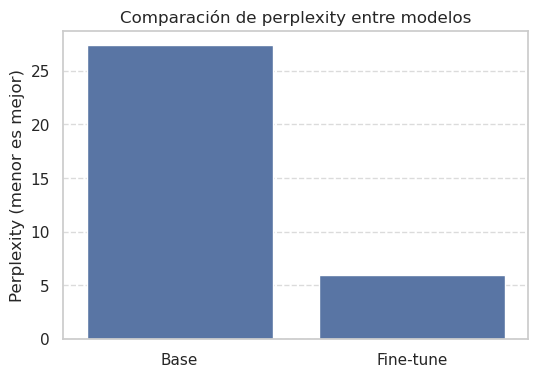

In [16]:
import math
from tqdm import tqdm

def evaluate_model_phi3(
    model,
    dataset,
    tokenizer,
    max_examples: int = 200,
    max_length: int = 2048,
):
    """
    Evaluates a causal LM on a dataset with a 'text' column (Phi-3 chat template).
    Computes mean cross-entropy loss and perplexity (exp(loss)) over the selected subset.

    Note: This is a global metric over the full sample (system + user + assistant).
    """
    model.eval()
    losses = []

    with torch.no_grad():
        for i, example in enumerate(tqdm(dataset, desc="Evaluando...")):
            if i >= max_examples:
                break

            text = example.get("text", None)
            if not isinstance(text, str) or not text.strip():
                continue

            enc = tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                max_length=max_length,
            )

            # Move tensors to a valid parameter device (works with device_map="auto")
            try:
                param_device = next(model.parameters()).device
                enc = {k: v.to(param_device) for k, v in enc.items()}
            except StopIteration:
                pass

            input_ids = enc["input_ids"]
            outputs = model(input_ids=input_ids, labels=input_ids)
            losses.append(float(outputs.loss))

    n = len(losses)
    avg_loss = sum(losses) / max(1, n)

    try:
        perp = math.exp(avg_loss)
    except OverflowError:
        perp = float("inf")

    return {"cross_entropy": avg_loss, "perplexity": perp, "n": n}


metrics_base = evaluate_model_phi3(
    base_model, datasets["validation"], tokenizer, max_examples=200, max_length=2048
)
metrics_fine = evaluate_model_phi3(
    fine_model, datasets["validation"], tokenizer, max_examples=200, max_length=2048
)

print("\nResultados de evaluación:")
print(
    f"Base model  → CE: {metrics_base['cross_entropy']:.3f} | "
    f"PPL: {metrics_base['perplexity']:.2f} | n={metrics_base['n']}"
)
print(
    f"Fine-tuned  → CE: {metrics_fine['cross_entropy']:.3f} | "
    f"PPL: {metrics_fine['perplexity']:.2f} | n={metrics_fine['n']}"
)

if metrics_base["perplexity"] != float("inf") and metrics_base["perplexity"] > 0:
    improvement = (
        (metrics_base["perplexity"] - metrics_fine["perplexity"])
        / metrics_base["perplexity"]
        * 100
    )
    print(f"Mejora relativa en perplexity: {improvement:.2f}%")
else:
    print("No se pudo calcular mejora relativa (perplexity base inválida).")

plt.figure(figsize=(6, 4))
sns.barplot(
    x=["Base", "Fine-tune"],
    y=[metrics_base["perplexity"], metrics_fine["perplexity"]],
)
plt.title("Comparación de perplexity entre modelos")
plt.ylabel("Perplexity (menor es mejor)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
